In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch import tensor, Tensor, optim
import torch.nn.functional as F 
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import Conv2d, InstanceNorm2d, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader, TensorDataset


from torchvision.utils import save_image, make_grid
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this won't work if the drive is shared with you
# solution: right click on the shared CS7643 project folder and select 'add shortcut to my drive'
%cd gdrive/My\ Drive/CS7643_Final_Project

In [ ]:
class bVAE(nn.Module):
  def __init__(self, latent_dim):
    super(bVAE, self).__init__()
    self.latent_dim = latent_dim
    # Encoder
    self.c1 = nn.Conv2d(1, 32, kernel_size = 4, stride = 2, padding = 1)
    self.b1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1)
    self.b2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.b3 = nn.BatchNorm2d(64)

    self.c4 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.b4 = nn.BatchNorm2d(64)

    self.fc1 = nn.Linear(64 * 6 * 6, latent_dim)
    self.fc2 = nn.Linear(64 * 6 * 6, latent_dim)

    # Decoder
    self.fc3 = nn.Linear(latent_dim, 64 * 6 * 6)

    self.d0 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.db0 = nn.BatchNorm2d(64)

    self.d1 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.db1 = nn.BatchNorm2d(64)
    self.d2 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1)
    self.db2 = nn.BatchNorm2d(32)
    self.d3 = nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2, padding = 1)
    self.db3 = nn.BatchNorm2d(1)
    self.sigmoid = nn.Sigmoid()
  
  def encode(self, x):
    out = F.relu(self.b1(self.c1(x)))
    out = F.relu(self.b2(self.c2(out)))
    out = F.relu(self.b3(self.c3(out)))
    out = F.relu(self.b4(self.c4(out)))
    # Resize from (batch_size, num_classes, w, h) to (batch_size,num_classes*w*h)
    out = out.view(out.shape[0], -1)
    mu, logvar = F.relu(self.fc1(out)), F.relu(self.fc2(out))
    return mu, logvar
  
  def decode(self, z):
    out = F.relu(self.fc3(z))
    out = out.view(-1, 64, 6, 6)
    out = F.relu(self.db0(self.d0(out)))
    out = F.relu(self.db1(self.d1(out)))
    out = F.relu(self.db2(self.d2(out)))
    return self.sigmoid(self.db3(self.d3(out)))
  
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [ ]:
class VAE_Loss(nn.Module):
  def __init__(self):
    super(VAE_Loss, self).__init__()
    self.beta = 3
  
  def forward(self, z_img, img, mu, logvar):
    BCE = torch.mean(F.binary_cross_entropy(z_img, img, reduction='sum'), dim = 0)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
    return BCE + self.beta * KLD

In [ ]:
batch_size = 128

In [ ]:
def load_data(batch_size = 128):
    """
    Returns a list of PyTorch DataLoaders in order of train, validation, and test loaders
    """
    dirnames = ['Train/', 'Validation/', 'Test/']
    loaders = []

    #scaler = StandardScaler()
    for dirname in dirnames:
        dataname = os.listdir(dirname)[0]
        xs = np.load(dirname + dataname)['data'].reshape(-1, 1, 28, 28)
        ys = np.load(dirname + dataname)['target']

        xs = Tensor(xs).to(device)
        ys = Tensor(ys, dtype = torch.long).to(device)

        xs /= 255
        mu = torch.mean(xs, dim = (0, 2, 3))
        std = torch.std(xs, dim = (0, 2, 3))

        transform = transforms.Compose([transforms.Normalize((mu,), (std,))])
        xs = transform(xs)

        print(f'Loading {dataname} into Pytorch Dataloader ... Xs shape: {xs.shape}, Ys shape: {ys.shape}')
        loaders.append(DataLoader(TensorDataset(xs, ys), batch_size = batch_size, shuffle=True))
    
    return loaders

In [ ]:
classes = ['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']

In [ ]:
train_data_loader, _, test_data_loader = load_data(batch_size)

In [ ]:
fixed_images, fixed_labels = next(iter(test_data_loader))

In [ ]:
def plot_samples(xs, ys, rows = 3):
    classes = ['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']
    num_classes = len(classes)
    '''
    Plots row number of samples from each class
    '''

    fig, axs = plt.subplots(figsize=(num_classes,rows))
    axs.axis('off')
    xs = xs.reshape(xs.shape[0], 28, 28)
    
    for i in range(rows * num_classes): 
        c = i % num_classes
        class_indices = np.argwhere(ys == c).squeeze()
        ci = i % len(class_indices)
        curr = class_indices[ci]
        
        a = fig.add_subplot(rows, num_classes, i + 1)

        imgplot = plt.imshow(xs[curr, :].reshape((28, 28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
def generate_samples(images, model):
  with torch.no_grad():
    out, _, _ = model(images)
  return out

In [ ]:
def evaluate_model(model, dataloader):
    """
    Calculates the average loss and accuracy of the model on a dataset
    """
    model.eval() # Notify all layers we're in eval mode instead of training mode
    loss = 0
    n = 0
    with torch.no_grad():
      for xs, _ in dataloader:
        out, mu, logvar = model(xs)
        loss += criterion(out, xs, mu, logvar).item()
        n += 1
    
    print(f'\nTest loss: {loss / n: .2f}')
    return loss / n

In [ ]:
model = bVAE(30).to(device)
optimizer = optim.Adam(params = model.parameters(), lr=5e-3)
criterion = VAE_Loss()

In [ ]:
epochs = 200
losses = []
best_loss = float('inf')

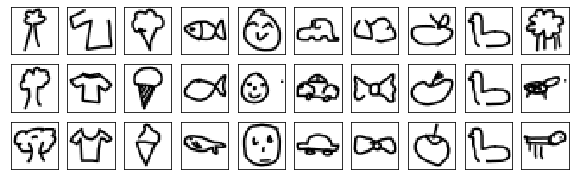

In [ ]:
# plot the actual test images
plot_samples(fixed_images.cpu().numpy(), fixed_labels.cpu().numpy(), rows = 3)

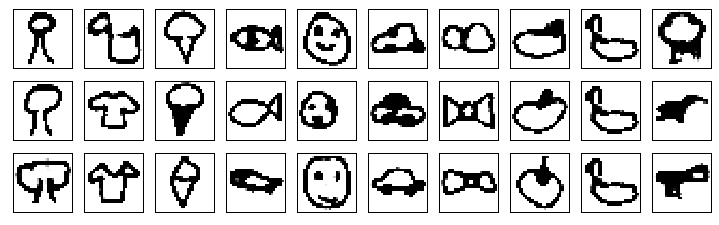

Epoch: 1, Avg Loss: -3915722.1922

Test loss: -3782803.65
Epoch: 2, Avg Loss: -3973009.9559

Test loss: -3839824.54
Epoch: 3, Avg Loss: -4011605.7275

Test loss: -3889594.32
Epoch: 4, Avg Loss: -4037756.9964

Test loss: -3888458.56
Epoch: 5, Avg Loss: -4061902.3023

Test loss: -3923460.66
Epoch: 6, Avg Loss: -4087230.9290

Test loss: -3945359.33
Epoch: 7, Avg Loss: -4110875.6322

Test loss: -3951506.41
Epoch: 8, Avg Loss: -4127396.6407

Test loss: -3953496.84
Epoch: 9, Avg Loss: -4142116.4380

Test loss: -4008504.93


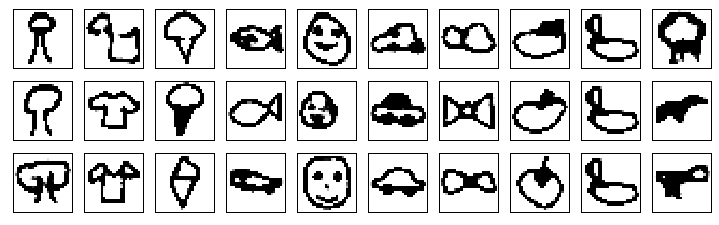

Epoch: 10, Avg Loss: -4164903.0401

Test loss: -3973217.12
Epoch: 11, Avg Loss: -4173820.9772

Test loss: -4028172.01
Epoch: 12, Avg Loss: -4183043.2587

Test loss: -4055178.28
Epoch: 13, Avg Loss: -4194283.3670

Test loss: -4026008.81
Epoch: 14, Avg Loss: -4206909.3272

Test loss: -4071570.72
Epoch: 15, Avg Loss: -4213787.7057

Test loss: -4072859.53
Epoch: 16, Avg Loss: -4223090.4302

Test loss: -4072372.24
Epoch: 17, Avg Loss: -4230582.8998

Test loss: -4080937.69


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(1, epochs + 1):
  total = 0
  n = 0
  for x, _ in train_data_loader:
    optimizer.zero_grad()
    out, mu, logvar = model(x)
    
    loss = criterion(out, x, mu, logvar)
    loss.backward()
    optimizer.step()

    total += loss.item()
    n += 1
  
  avg_loss = total / n
  losses.append(avg_loss)

  
  if avg_loss < best_loss:
    best_loss = avg_loss
    with open('bVAE_Quickdraw.pt', 'wb') as f:
      torch.save(model.state_dict(), f)
  
  if epoch == 1 or epoch % 10 == 0:
    model.eval()
    outputs = generate_samples(fixed_images.to(device), model)
    plot_samples(outputs.cpu().numpy(), fixed_labels.cpu().numpy())
    model.train()

  print('Epoch: {}, Avg Loss: {:.4f}'.format(epoch, avg_loss))
  evaluate_model(model, test_data_loader)
  model.train()
  epoch += 1

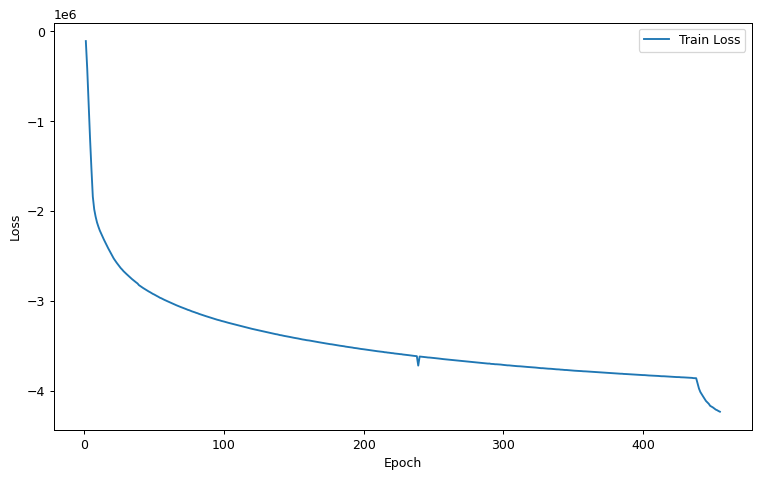

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 90
#plt.plot(list(range(1, epochs + 1)), losses)
plt.plot(list(range(1, 456)), losses)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

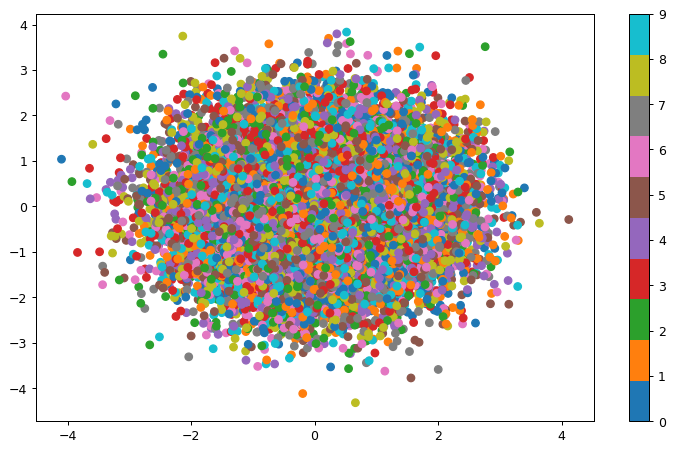

In [ ]:
# visualize latent space
for i, (x, y) in enumerate(test_data_loader):
  mu, logvar = model.encode(x.to(device))
  z = model.reparameterize(mu, logvar)
  z = z.to('cpu').detach().numpy()
  plt.scatter(z[:, 0], z[:, 2], c = y.cpu(), cmap = 'tab10')
plt.colorbar()

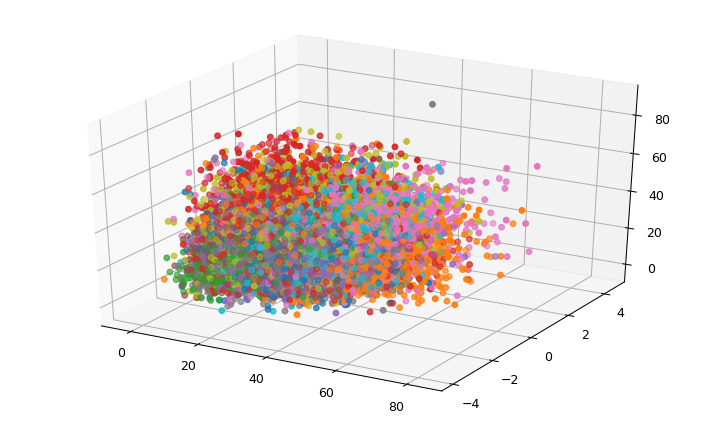

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, (x, y) in enumerate(test_data_loader):
  mu, logvar = model.encode(x.to(device))
  z = model.reparameterize(mu, logvar)
  z = z.to('cpu').detach().numpy()
  ax.scatter(z[:, 12], z[:, 2], z[:, 3], c = y.cpu(), cmap = 'tab10')


In [ ]:
evaluate_model(model, test_data_loader)


Test loss: -4102635.65


-4102635.651595745

In [ ]:
evaluate_model(model, train_data_loader)


Test loss: -4253318.05


-4253318.050228311